# Generating Names with a Character-Level RNN

Source
http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

---
## Dataprep
(exact same as before)

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

In [2]:
def find_files(path): return glob.glob(path)

In [3]:
def unicode_to_ascii(s):
    # Turn a Unicode string to plain ASCII
    # http://stackoverflow.com/a/518232/2809427
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [4]:
def read_lines(filename):
    # Read a file and split into lines
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

---
## Network Creation

![structure](assets/jzVrf7f.png)

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
    
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

---
## Data Sampling

In [8]:
import random
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

In [9]:
def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [45]:
def category_tensor(category):
    # one-hot tensor for category
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [11]:
def input_tensor(line):
    # one-hot matrix of input letters, excl. EOS
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [12]:
def target_tensor(line):
    # LongTensor for 2nd letter to last (EOS) for target
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [13]:
def random_training_example():
    # random X,y example fetcher for convenience
    category, line = random_training_pair()
    cat_tensor = Variable(category_tensor(category))
    input_line_tensor = Variable(input_tensor(line))
    target_line_tensor = Variable(target_tensor(line))
    return cat_tensor, input_line_tensor, target_line_tensor

---
## Training

In [14]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

In [20]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
        
    loss.backward()
    
    # add weight gradients x learning rate to weights
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.data[0] / input_line_tensor.size()[0]

In [21]:
from time import time
from math import floor

def time_since(since):
    now = time()
    s = now - since
    m = floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [22]:
rnn = RNN(n_letters, 128, n_letters)

In [23]:
n_iters = 100000
print_every = 5000
plot_every = 500

total_loss = 0
all_losses = []

In [24]:
start = time()

for iter in range(1, 1 + n_iters):
    output, loss = train(*random_training_example())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 13s (5000 5%) 2.7602
0m 27s (10000 10%) 2.6147
0m 41s (15000 15%) 2.9294
0m 55s (20000 20%) 2.9678
1m 10s (25000 25%) 2.2505
1m 24s (30000 30%) 1.9719
1m 37s (35000 35%) 3.0272
1m 51s (40000 40%) 2.5914
2m 5s (45000 45%) 2.2283
2m 19s (50000 50%) 2.7575
2m 33s (55000 55%) 2.0935
2m 46s (60000 60%) 2.2204
3m 0s (65000 65%) 2.6099
3m 14s (70000 70%) 2.3881
3m 27s (75000 75%) 2.4479
3m 40s (80000 80%) 1.7780
3m 53s (85000 85%) 2.3115
4m 6s (90000 90%) 2.4892
4m 19s (95000 95%) 1.7230
4m 32s (100000 100%) 1.4633


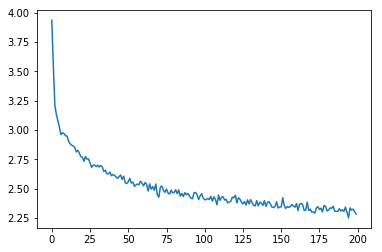

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

---
# Sampling
+ provide first char, predict next char, repeat until net predicts EOS token.
+ to let net choose start, include SOS token in training.

In [69]:
max_length = 20

def sample(category, start_letter='A'):
    cat_tensor = Variable(category_tensor(category))
    input = Variable(input_tensor(start_letter))
    hidden = rnn.init_hidden()
    
    output_name = start_letter
    
    for i in range(max_length):
        output, hidden = rnn(cat_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(input_tensor(letter))
    
    return output_name

In [70]:
def samples(category, start_letters='ABC'):
    # multiple samples, same category, multiple starts
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [72]:
samples('English', 'ZVO')
samples('Arabic', 'ZVO')

Zanter
Vanton
Oringer
Zaras
Vara
Oarah


---
## Going Further

Change data:
+ fictional series -> character name
+ part of speech -> word
+ country -> city

Add SOS token for autonomous sampling

Use bigger and/or better net:
+ try LSTM and GRU layers
+ combine multiple RNNs to higher level net

---